### Package Versions

- **Python version**: `3.9.13`
- **NumPy version**: `1.23.5`
- **Matplotlib version**: `3.4.2`
- **SciPy version**: `1.9.1`
- **Pandas version**: `1.5.3`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks, stft
import pandas as pd

## Section a)

In [6]:
def gentone(key='#', T=1, dt=1e-6):
    """ 
    gentone function that can generate the tone associated with any key of the keypad from 0 to 9 plus # and *

    Parameters
    ----------
    key : str, optional
        The key for which the tone is produced, by default is '#'
    T: float, optional
        The duration of signal [seconds], by default 1
    dt: float, optional
        Sampling time step [seconds], by default 1e-6
        By choosing this sampling rate we ensure we are capturing all the frequencies 
        (the sampling rate is faster than Nyquist frequency of highest frequency)

    Returns
    ----------
    t : numpy.ndarray
        Time array from 0 to T
    signal : numpy.ndarray
        Signal points corresponding to the time array
    """

    # Validate input key
    valid_keys = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '*', '#']
    if key not in valid_keys:
        raise ValueError(f"Invalid key '{key}'. Must be one of {valid_keys}.")

    # Time points
    t = np.arange(0, T, dt)

    # Keypad keys in a (4 by 3) matrix
    keypad_keys = np.array([['1', '2', '3'],
                            ['4', '5', '6'],
                            ['7', '8', '9'],
                            ['*', '0', '#']])

    # Frequencies related to each row and column of keypad
    row_frequencies = np.array([697, 770, 852, 941])
    column_frequencies = np.array([1209, 1336, 1477])

    # Find row and column index for the selected key
    ri, cj = np.where(keypad_keys == key)

    # Ensure ri and cj are scalar indices
    ri = ri[0]
    cj = cj[0]

    # Generate signal points 
    signal = 0.5 * (np.sin(2 * np.pi * row_frequencies[ri] * t) +
                    np.sin(2 * np.pi * column_frequencies[cj] * t))

    return t, signal

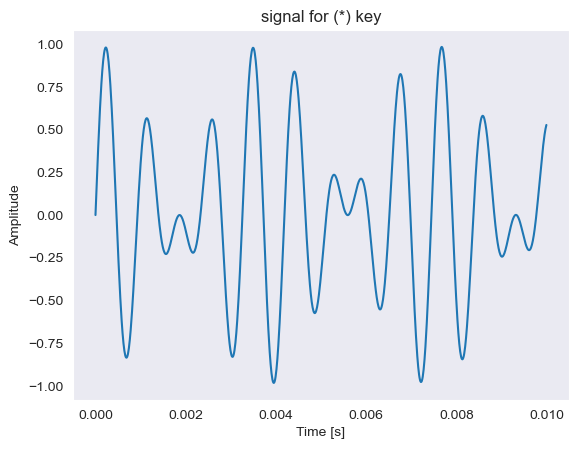

In [9]:
# select the key 
selected_key = '*'
# Generate tone for key '5'
t, signal = gentone(key=selected_key, T=0.01, dt=1e-5)  # Shorter duration and larger time step for quick plotting

# Plot the signal as a function of time
plt.plot(t, signal)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('signal for (' + selected_key + ') key')
plt.grid()
plt.show()


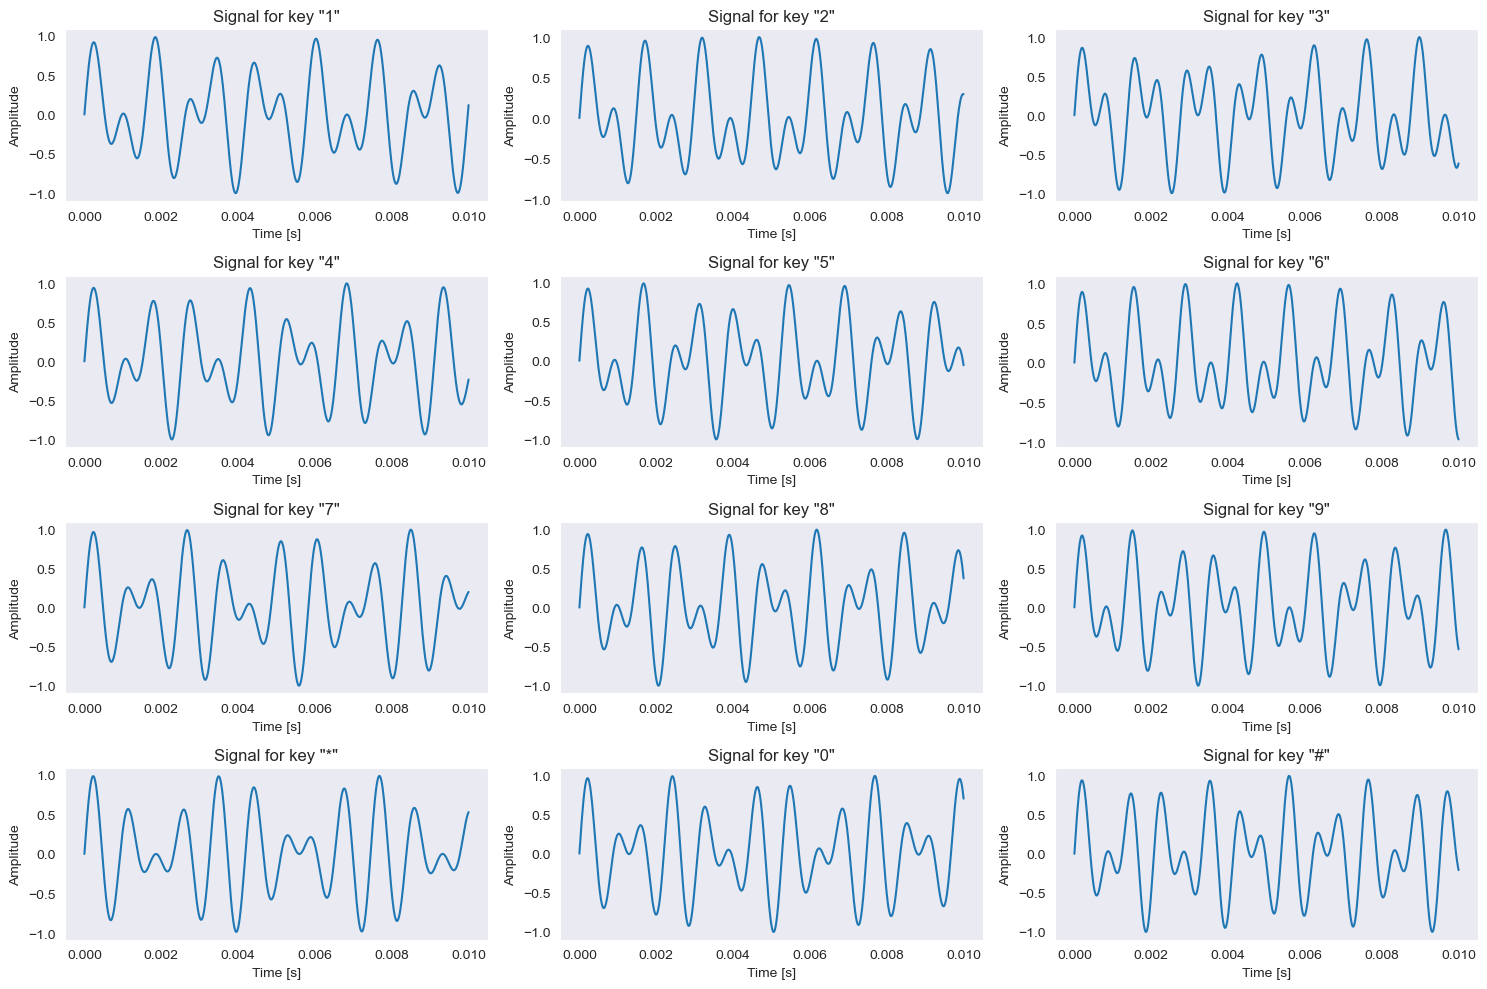

In [10]:
# List of all keypad keys to iterate over and generate their corresponding tones
keypad_keys = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '*', '0', '#']

# Create subplots with a 4 (rows) by 3 (columns) grid to match the physical keypad layout
# figsize defines the size of the entire figure in inches (width, height)
fig, axs = plt.subplots(4, 3, figsize=(15, 10))

# Loop over all keys and generate corresponding plots
for idx, key in enumerate(keypad_keys):
    # Calculate the row and column index for the subplot grid
    # `idx // 3` gives the row index and `idx % 3` gives the column index
    row = idx // 3
    col = idx % 3

    # Generate the tone for the current key using the gentone function
    # T is the total duration (0.01 seconds), dt is the time step (1e-4 seconds)
    t, signal = gentone(key=key, T=0.01, dt=1e-5)  # Shorter duration and larger time step for faster plotting

    # Plot the signal in the corresponding subplot
    axs[row, col].plot(t, signal)
    axs[row, col].set_title(f'Signal for key "{key}"')
    axs[row, col].set_xlabel('Time [s]')
    # Label the y-axis as 'Amplitude' since it represents the signal amplitude
    axs[row, col].set_ylabel('Amplitude')
    # Enable grid for better visualization of the plot
    axs[row, col].grid()

# Adjust the layout to make sure there is enough space between plots to prevent overlap
plt.tight_layout()
# Display the figure with all the subplots
plt.show()


## Section b)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

def fft_and_peak_detector(signal, dt):
    """
    Perform FFT on the input signal, plot the FFT spectrum, and detect peaks.

    Parameters
    ----------
    signal : numpy.ndarray
        The signal on which to perform the FFT.
    dt : float
        Time step of the signal in seconds.

    Returns
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        Plot of FFT amplitude vs. frequencies between -2000 Hz and 2000 Hz.
    peak_freqs : numpy.ndarray
        Frequencies of peaks detected in the FFT spectrum, rounded to 2 decimal places.
    """

    # Creating result figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Perform FFT using scipy.fft method
    fft_signal = fft(signal)
    # Compute frequency bins corresponding to the FFT values
    freqs = fftfreq(len(signal), d=dt)

    # Plotting the FFT spectrum of the signal
    ax.plot(freqs, np.abs(fft_signal), linestyle='--', color='g', label='FFT Amplitude')

    # Finding the peaks of the FFT using the find_peaks method from scipy.signal
    peaks, properties = find_peaks(np.abs(fft_signal), height=1)
    peak_freqs = freqs[peaks]

    # Select peaks within the frequency range of -2000 to 2000 Hz
    valid_peak_indices = np.logical_and(peak_freqs < 2000, peak_freqs > -2000)
    peak_freqs = peak_freqs[valid_peak_indices]

    # Marking the peaks in the FFT plot
    ax.vlines(x=peak_freqs, ymin=0, ymax=1.1 * np.max(properties['peak_heights']), color='r', linewidth=0.7, label='Detected Peaks')

    # Annotating each detected peak with its frequency
    for peak_freq in peak_freqs:
        ax.text(x=peak_freq, y=0.5 * np.max(properties['peak_heights']), s=f'{peak_freq:.2f} Hz', fontsize=9, color='b')

    # Set plot configurations
    ax.set_xlim(-2000, 2000)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.set_title("FFT of the Selected Signal")
    ax.grid(alpha=0.5)
    ax.legend()

    # Return the axis and rounded peak frequencies
    return ax, np.round(peak_freqs, 2)



In [19]:
def identify_key_from_frequencies(peak_freqs):
    """
    Identify the pressed key on a telephone keypad given the detected frequencies.

    Parameters
    ----------
    peak_freqs : numpy.ndarray
        Array of detected frequencies (in Hz) from the FFT.

    Returns
    ----------
    key : str
        The key that corresponds to the detected frequencies.
    """

    # Define the standard row frequencies of a DTMF keypad (in Hz)
    row_frequencies = [697, 770, 852, 941]
    # Define the standard column frequencies of a DTMF keypad (in Hz)
    column_frequencies = [1209, 1336, 1477]

    # Define tolerance to allow for minor variations in the detected frequencies (in Hz)
    tolerance = 10  # Hz

    # Sort the detected frequencies to differentiate between row and column frequencies
    # Row frequencies are always lower than column frequencies, making sorting useful for classification
    sorted_freqs = np.sort(peak_freqs)

    # Initialize variables to store matched row and column frequencies
    matched_row_freq = None
    matched_col_freq = None

    # Identify the matched row frequency
    # Iterate over each row frequency to find the closest match within the tolerance
    for row_freq in row_frequencies:
        # Check if any frequency in sorted_freqs is within the specified tolerance of the current row frequency
        if any(np.abs(sorted_freqs - row_freq) < tolerance):
            matched_row_freq = row_freq
            break  # Exit the loop once a match is found

    # Identify the matched column frequency
    # Iterate over each column frequency to find the closest match within the tolerance
    for col_freq in column_frequencies:
        # Check if any frequency in sorted_freqs is within the specified tolerance of the current column frequency
        if any(np.abs(sorted_freqs - col_freq) < tolerance):
            matched_col_freq = col_freq
            break  # Exit the loop once a match is found

    # Define the mapping from (row frequency, column frequency) pairs to corresponding keypad keys
    key_mapping = {
        (697, 1209): '1', (697, 1336): '2', (697, 1477): '3',
        (770, 1209): '4', (770, 1336): '5', (770, 1477): '6',
        (852, 1209): '7', (852, 1336): '8', (852, 1477): '9',
        (941, 1209): '*', (941, 1336): '0', (941, 1477): '#'
    }

    # Determine the pressed key using the matched row and column frequencies
    if matched_row_freq is not None and matched_col_freq is not None:
        # Look up the key in the mapping using the matched frequencies
        key = key_mapping.get((matched_row_freq, matched_col_freq), "Unknown key")
    else:
        # If either row or column frequency could not be matched, return "Unknown key"
        key = "Unknown key"

    return key


The `identify_key_from_frequencies` function takes in an array of detected frequencies from an FFT analysis and determines which key on a telephone keypad was pressed based on the standard Dual-Tone Multi-Frequency (DTMF) system.
#### Key Concepts
The function utilizes the DTMF system, which is used in telephone signaling to dial numbers. Each key on the telephone keypad is associated with a unique combination of two frequencies: a **row frequency** and a **column frequency**.

- **Row Frequencies**: 697 Hz, 770 Hz, 852 Hz, 941 Hz
- **Column Frequencies**: 1209 Hz, 1336 Hz, 1477 Hz

The function determines the key pressed by:
1. **Sorting** the detected frequencies to distinguish between row and column frequencies (since row frequencies are always lower than column frequencies).
2. Matching the sorted frequencies with predefined values within a **tolerance** of 10 Hz to account for variations in detection.

#### Function Steps
1. **Define Row and Column Frequencies**:
   The function starts by defining the **row** and **column** frequencies that represent the DTMF keypad. These frequencies are used to identify the pressed key.

2. **Set Frequency Tolerance**:
   The function sets a tolerance of **10 Hz** to accommodate small variations in the detected frequencies due to noise or sampling errors.

3. **Sort the Detected Frequencies**:
   The detected frequencies (`peak_freqs`) are **sorted** to help differentiate between row and column frequencies, as row frequencies are always lower than column frequencies.

4. **Identify Matched Row and Column Frequencies**:
   - The function iterates through the row frequencies and checks if any of the sorted frequencies are within the tolerance range.
   - Similarly, it iterates through the column frequencies to find a matching frequency.
   - The matched row and column frequencies are saved.

5. **Map Frequencies to Keys**:
   The function then uses a **dictionary** (`key_mapping`) to map the combination of matched row and column frequencies to the corresponding key on the keypad.

6. **Return the Identified Key**:
   - If both a row and a column frequency are successfully matched, the function returns the corresponding key using the dictionary.
   - If either of the frequencies could not be matched, the function returns `"Unknown key"`.


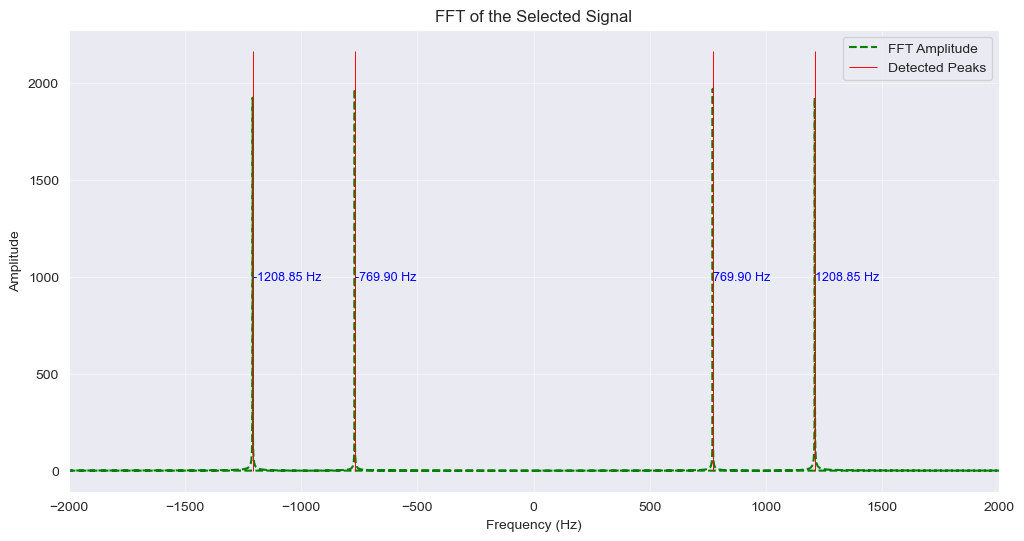

Detected Peak Frequencies (Hz): [  769.9   1208.85 -1208.85  -769.9 ]
Detected Key: 4


In [20]:
# Example usage with the existing signal and FFT analysis
# Generate a sample signal to test the function
t = np.linspace(0, 1, 8000)  # 1 second duration, 8000 samples
signal = 0.5 * (np.sin(2 * np.pi * 770 * t) + np.sin(2 * np.pi * 1209 * t))  # Sample DTMF tone

# Call the FFT function and plot the FFT with peak detection
ax, peak_freqs = fft_and_peak_detector(signal, dt=(t[1] - t[0]))
plt.show()

# Print detected peak frequencies
print("Detected Peak Frequencies (Hz):", peak_freqs)

# Identify the pressed key based on the detected frequencies
detected_key = identify_key_from_frequencies(peak_freqs)
print("Detected Key:", detected_key)

## Section c)

I added Ornstein-Uhlenbeck noise to the signal. The Ornstein-Uhlenbeck noise is modeled by the following stochastic differential equation:

$$
dx = -\gamma x \, dt + g \, \sqrt{dt} \cdot N(0, 1)
$$

Where:
- $ x $ is the current value of the noise process.
- $ \gamma $ is the mean reversion rate.
- $ g $ is the noise intensity factor.
- $N(0, 1) $ is a normally distributed random variable with mean `0` and variance `1`.
- $ \sqrt{dt} $ scales the noise contribution appropriately for the time step size.

The process generates a value at each time step $ t_i $ by applying a combination of:
- **Mean reversion**: $ -\gamma x \, dt $, which pulls the signal back towards zero.
- **Random fluctuation**: $g \, \sqrt{dt} \cdot N(0, 1) $, which adds a random Gaussian perturbation to the signal.

The result is a noise signal that is:
- **Mean-reverting**: It tends to return to zero over time.
- **Smooth**: Compared to white noise, the process evolves more gradually.


In [21]:
import numpy as np

def OU_noise(dt, T, gamma=10, g=0.5):
    """
    Generates an Ornstein–Uhlenbeck (OU) process, a stochastic signal that represents bounded noise.

    Parameters
    ----------
    dt : float
        Time step for the simulation (seconds).
    T : float
        Total time duration of the signal (seconds).
    gamma : float, optional
        Decay rate or mean reversion strength (default is 10). Determines how quickly the process tends towards its mean.
    g : float, optional
        Noise intensity factor, controlling the amplitude of random fluctuations (default is 0.5).

    Returns
    ----------
    ou_noise : numpy.ndarray
        Array representing the Ornstein–Uhlenbeck noise signal over time.
    """

    # Initialize the process variable to start at zero
    current_value = 0.0

    # Calculate the number of time steps
    N = int(T / dt)

    # Initialize an array to store the generated OU noise values
    ou_noise = np.zeros(N)

    # Loop through each time step to generate the OU noise
    for i in range(N):
        # Update the process value based on the Ornstein-Uhlenbeck differential equation
        # dx = -gamma * x * dt + g * sqrt(dt) * N(0, 1)
        current_value = current_value - gamma * current_value * dt + g * np.random.normal() * np.sqrt(dt)

        # Store the updated value in the output array
        ou_noise[i] = current_value

    return ou_noise

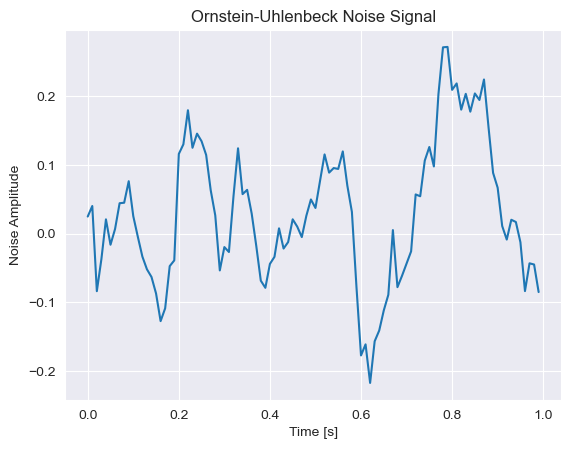

In [22]:
dt = 0.01  # Time step of 0.01 seconds
T = 1.0    # Total duration of 1 second
gamma = 5  # Decay rate
g = 0.5    # Noise intensity factor

noise_signal = OU_noise(dt, T, gamma, g)

# Plotting the generated Ornstein-Uhlenbeck noise signal
import matplotlib.pyplot as plt
plt.plot(np.arange(0, T, dt), noise_signal)
plt.xlabel('Time [s]')
plt.ylabel('Noise Amplitude')
plt.title('Ornstein-Uhlenbeck Noise Signal')
plt.grid(True)
plt.show()